Vanilla GAN from this website

https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/VanillaGAN.ipynb

https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/Conditional-GAN.ipynb


Combine into a DCGAN - 1D

https://github.com/LixiangHan/GANs-for-1D-Signal/blob/main/dcgan.py



In [1]:
!pip install torch torchvision


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image


In [4]:
!pip install torchinfo
from torchinfo import summary


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import datetime
import os, sys

In [6]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [7]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def to_onehot(x, num_classes=2):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [9]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    #img = np.zeros([280, 280])
    for j in range(2):
        c = torch.zeros([10, 2]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE) # number of random noise vectors created = 10
        y_hat = G(z,c).view(10, 3, 1000) #(10, 3, 1000)
        #result = y_hat.cpu().data.numpy()
        if j == 0: # this is a left movement
          data_left = y_hat.cpu().data.numpy()
        else:
          data_right = y_hat.cpu().data.numpy()
    return data_left, data_right

In [10]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=3000, condition_size=2, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 2048),
#            nn.LeakyReLU(0.2),
#            nn.Linear(4096, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x, c):

        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        return y_

In [11]:

# Define model and inputs
model = Discriminator(input_size=3000, condition_size=2, num_classes = 1) # is num_classes teh number of classifications?
batch_size = 16
input_size = (batch_size, 3, 1000)  # Adjust based on your use case
class_label_size = (batch_size, 2)

# Summarize model
summary(
    model,
    input_size=(input_size, class_label_size),
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    depth=3
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Discriminator                            [16, 3, 1000]             [16, 1]                   --                        --                        --
├─Sequential: 1-1                        [16, 3002]                [16, 1]                   --                        --                        --
│    └─Linear: 2-1                       [16, 3002]                [16, 2048]                6,150,144                 --                        98,402,304
│    └─LeakyReLU: 2-2                    [16, 2048]                [16, 2048]                --                        --                        --
│    └─Linear: 2-3                       [16, 2048]                [16, 1024]                2,098,176                 --                        33,570,816
│    └─LeakyReLU: 2-4                    [16, 1024]                [16, 1024]            

In [34]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, condition_size=2, num_classes=3000): # flag for later, should this be
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
           # nn.Linear(1024, 2048),
           # nn.BatchNorm1d(2048),
           # nn.LeakyReLU(0.2),
           # nn.Linear(2048, 4096),
           # nn.BatchNorm1d(4096),
           # nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        y_ = y_.view(x.size(0), 3, 1000)
        return y_

In [35]:
# Define model and inputs
model = Generator(input_size=100, condition_size=2)
batch_size = 16
input_size = (batch_size, 100)  # Adjust based on your use case
class_label_size = (batch_size, 2)

# Summarize model
summary(
    model,
    input_size=(input_size, class_label_size),
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    depth=3
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Generator                                [16, 100]                 [16, 3, 1000]             --                        --                        --
├─Sequential: 1-1                        [16, 102]                 [16, 3000]                --                        --                        --
│    └─Linear: 2-1                       [16, 102]                 [16, 128]                 13,184                    --                        210,944
│    └─LeakyReLU: 2-2                    [16, 128]                 [16, 128]                 --                        --                        --
│    └─Linear: 2-3                       [16, 128]                 [16, 256]                 33,024                    --                        528,384
│    └─BatchNorm1d: 2-4                  [16, 256]                 [16, 256]                 51

In [36]:
n_noise = 100

In [37]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [38]:
data = []
temps = []
labels = []
t = np.linspace(0, 4, num=1000)

for i in range(3240):
  indicator = np.random.randint(0,2)
  for j in range(3):
    variation_add = np.random.uniform(-.1,.1)
    if indicator == 0:  #left movement
      temps.append( (0.5 + variation_add) *np.sin(50*t) + 0.5)
      data += temps
      if j == 0:
        labels.append(0)
    else:
      temps.append( (0.5+variation_add) *np.cos(50*t) + 0.5)
      if j==0:
        labels.append(1)

data = np.array(temps).reshape(3240,3,1000)
label = np.array(labels).reshape(3240,1)


In [39]:
class Sine_Cosine_Dataset(Dataset):
  def __init__(self, data, labels, transform=None):
    self.data = data
    self.labels = labels
    self.transform=transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data = self.data[index]
    label = self.labels[index]

    if self.transform:
      data = self.transform(data)

    return data, label

In [40]:
dataset = Sine_Cosine_Dataset(data, labels)

In [41]:
batch_size = 128
condition_size=2

In [42]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [43]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [48]:
max_epoch = 100 # need more than 10 epochs for training generator
step = 0
n_critic = 2 # for training more k steps about Discriminator

In [49]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [50]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [57]:
Discriminator_loss = []
Generator_loss = []
steps = []
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE).float()
        y = labels.view(batch_size, 1)
        y = to_onehot(y).to(DEVICE)
        x_outputs = D(x, y)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        
            
        step += 1
        print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        Discriminator_loss.append(D_loss.item())
        Generator_loss.append(G_loss.item())
        steps.append(step)

        #if step % 1000 == 0:
           # G.eval()
            #img = get_sample_image(G, n_noise)
            #imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            #G.train()

        #step += 1

Epoch: 0/100, Step: 2501, D Loss: 0.9862566590309143, G Loss: 2.171881914138794
Epoch: 0/100, Step: 2502, D Loss: 0.9865607023239136, G Loss: 2.171881914138794
Epoch: 0/100, Step: 2503, D Loss: 0.9127912521362305, G Loss: 2.735309362411499
Epoch: 0/100, Step: 2504, D Loss: 1.3785102367401123, G Loss: 2.735309362411499
Epoch: 0/100, Step: 2505, D Loss: 1.3863182067871094, G Loss: 0.9590350389480591
Epoch: 0/100, Step: 2506, D Loss: 1.5050280094146729, G Loss: 0.9590350389480591
Epoch: 0/100, Step: 2507, D Loss: 1.206505537033081, G Loss: 2.8812899589538574
Epoch: 0/100, Step: 2508, D Loss: 1.2087032794952393, G Loss: 2.8812899589538574
Epoch: 0/100, Step: 2509, D Loss: 1.3628356456756592, G Loss: 1.4090681076049805
Epoch: 0/100, Step: 2510, D Loss: 1.299233317375183, G Loss: 1.4090681076049805
Epoch: 0/100, Step: 2511, D Loss: 1.4499958753585815, G Loss: 0.37829434871673584
Epoch: 0/100, Step: 2512, D Loss: 1.530503511428833, G Loss: 0.37829434871673584
Epoch: 0/100, Step: 2513, D Loss:

<function matplotlib.pyplot.show(close=None, block=None)>

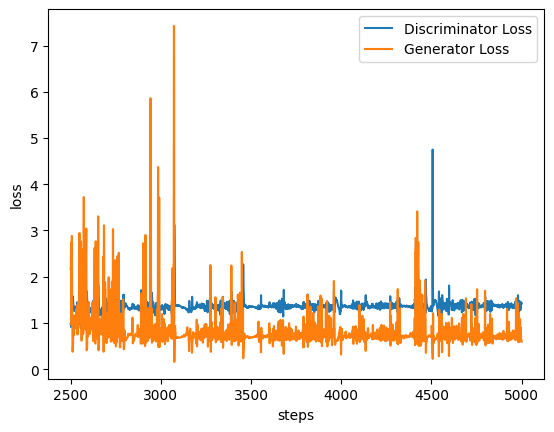

In [62]:
import matplotlib.pyplot as plt
#print(steps)
plt.plot(steps, Discriminator_loss)
plt.plot(steps, Generator_loss)
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show

In [59]:
G.eval()
data_left, data_right = get_sample_image(G, n_noise)
x = np.linspace(0, 4, num=1000)

<function matplotlib.pyplot.show(close=None, block=None)>

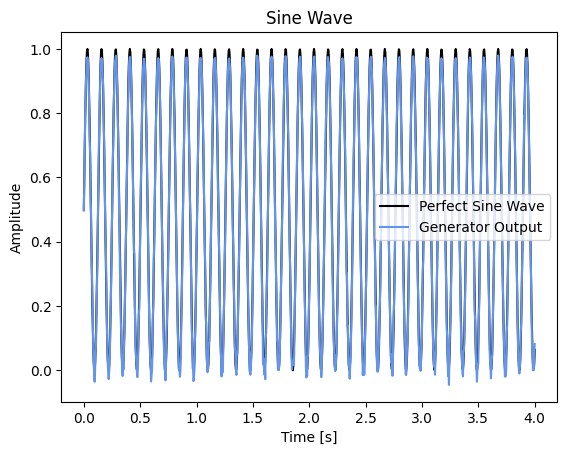

In [83]:
#This is for the Left

plt.plot(x, .5*np.sin(50*x)+.5, label = 'Perfect Sine Wave', color='black')
plt.plot(x, data_left[9,1,:], label='Generator Output', color='cornflowerblue')



plt.ylabel('Amplitude')
plt.title('Sine Wave')
plt.xlabel('Time [s]')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

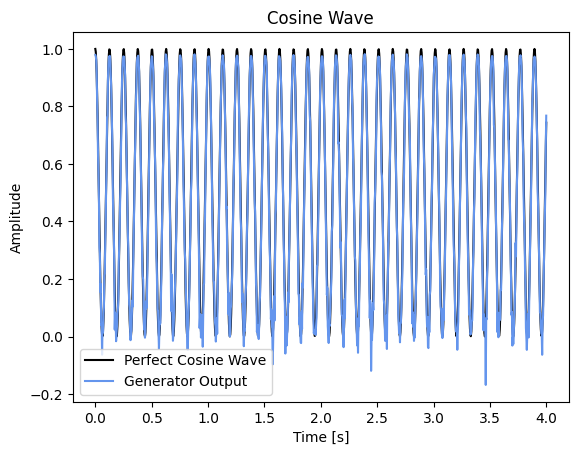

In [81]:
#This is for The right
plt.plot(x, .5*np.cos(50*x)+.5, label='Perfect Cosine Wave', color='black')
plt.plot(x, data_right[9,1,:], label='Generator Output', color='cornflowerblue')

plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.title('Cosine Wave')
plt.legend()
plt.show